# Agent-based model

This is a model of embryonic neocortex population, using an agent-based framework.
This means that we create cells, on we sample a Tc from the age-related distribution.
At the end of cell cycle, the fate decision for the daughters are.

The model starts at E48, where we have the first data.

Data will be of different types :

Tc:
- Population level estimation
- Cell level estimation

Differentiation:
- Cell level estimation

Number of progenitors:
- Ki67 ratio in GZ
- Ratio of Tbr2+ and Sox2+

Number of cells:
- Relative volume from Histo + MRI
- Density of cells

We will have to discuss quality of the data

In [1]:
# imports
import numpy as np
import seaborn as sns
import tqdm
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
from numpy.random import choice
from scipy.interpolate import splev, splrep, interp1d
from scipy import stats
from gpn2 import GrowingPlanarNetwork
from collections import Counter
from model import AbstractCell, Action, Brain, Submodels
from experiment import Experiment
from utils import nop, highest_lower, Profiler, plot_function
from submodels.cellbasic1 import CellBasic
from submodels.bistate1 import BiStateModelFactory
from submodels import factories
from tree import tree_from_cell

## Loading data

In [2]:
# Volume MRI + Histo
volumes = pd.read_csv('data/VolumeArea17.csv')

## Preprocessing data

In [3]:
# from PolynomRegression
Tc_ = lambda time: 277.36424309532794 - 0.023973977538587 * time - 0.761568634472077 * time**2 + \
    0.025594287611410 * time**3 - 0.000307496975562 * time**4 + 0.000001264230759 * time**5
print("Polynom Reg", Tc_(48), Tc_(65), Tc_(78))

Polynom Reg 41.8919627067869 64.8715873071742 55.96794765296363


In [4]:
# what we do is to average some ages
volumes = volumes.append(volumes.loc[volumes.Age.isin([70, 72])].mean(), ignore_index=True)
volumes = volumes.append(volumes.loc[volumes.Age.isin([78, 79])].mean(), ignore_index=True)
volumes = volumes.append(volumes.loc[volumes.Age.isin([84, 86])].mean(), ignore_index=True)
volumes = volumes.loc[~volumes.Age.isin([70, 72, 78, 79, 84, 86])]

In [5]:
col = volumes.loc[:, ["Ratio_Histo_VZ", "Ratio_MRI_VZ"]]
volumes['Ratio_VZ'] = col.mean(axis=1)
col = volumes.loc[:, ["Ratio_Histo_ISVZ", "Ratio_MRI_ISVZ"]]
volumes['Ratio_ISVZ'] = col.mean(axis=1) * volumes.loc[0, "Histo_ISVZ"] / volumes.loc[0, "Histo_VZ"]
col = volumes.loc[:, ["Ratio_Histo_OSVZ", "Ratio_MRI_OSVZ"]]
volumes['Ratio_OSVZ'] = col.mean(axis=1) * volumes.loc[0, "Histo_OSVZ"] / volumes.loc[0, "Histo_VZ"]

In [6]:
volumes.loc[:, ["AverageDensityVZ", "AverageDensityISVZ", "AverageDensityOSVZ"]] /= \
    volumes.loc[0, "AverageDensityVZ"]
volumes["total_cell_number"] = volumes["AverageDensityVZ"] * volumes["Ratio_VZ"] + \
                               volumes["AverageDensityISVZ"] * volumes["Ratio_ISVZ"] + \
                               volumes["AverageDensityOSVZ"] * volumes["Ratio_OSVZ"]
volumes.head()

,Age,Histo_VZ,Histo_ISVZ,Histo_OSVZ,Histo_SP,Histo_CP,MRI_VZ,MRI_ISVZ,MRI_OSVZ,MRI_SP,...,RelativeDensityVZ,RelativeDensityISVZ,RelativeDensityOSVZ,AverageDensityVZ,AverageDensityISVZ,AverageDensityOSVZ,Ratio_VZ,Ratio_ISVZ,Ratio_OSVZ,total_cell_number
0,49.0,0.264,0.118,0.012,NaN,0.056,0.527,0.236,0.024,NaN,...,1.000,1.00,1.000,1.000000,0.441331,0.044134,1.0000,0.446970,0.045455,1.199268
1,63.0,0.716,0.428,3.666,NaN,2.284,1.161,0.698,5.871,4.807,...,0.820,1.34,10.540,0.821235,0.592874,0.465094,2.4590,1.474330,12.733250,8.815673
8,94.0,0.910,0.767,6.152,NaN,15.344,NaN,NaN,NaN,NaN,...,0.230,0.28,2.800,0.234263,0.121405,0.123754,3.4520,2.909773,23.732864,4.098968
9,71.0,0.615,0.498,5.095,NaN,3.962,1.880,1.486,15.337,17.782,...,0.545,0.93,7.330,0.542118,0.409147,0.323570,2.9495,2.352625,24.617727,10.527115
10,78.5,0.374,0.342,4.686,NaN,5.366,1.030,0.957,12.835,17.322,...,0.480,0.88,5.495,0.477197,0.387065,0.242614,1.6895,1.556795,21.415750,6.604573


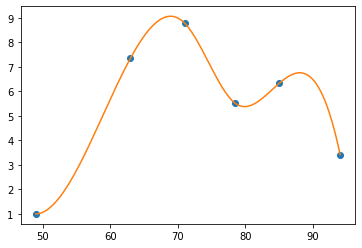

In [7]:
# complicated stuff to sort the list
sorted_number_cells = tuple(zip(*tuple(sorted(list(zip(volumes["Age"],
                                                       volumes["total_cell_number"] /
                                                       volumes.loc[0, "total_cell_number"])),
                                              key=lambda x: x[0]))))
spl = splrep(*sorted_number_cells)
x2 = np.linspace(49, 94, 200)
y2 = splev(x2, spl)
plt.plot(*sorted_number_cells, 'o', x2, y2)
plt.show()

In [8]:
def callback():
    plt.plot(*sorted_number_cells, 'o', x2, y2)

In [9]:
# Cell fate will be the first parameter to tune

### Ratio Tbr2

In [10]:
# From Betizeau et al.

ratio_eomes = pd.DataFrame({"VZ": [16.6, 13.3, 20, 43.3, 58.3],
                            "ISVZ": [88.3, 81.6, 81.6, 83.3, 75.0],
                            "OSVZ": [63.3, 43.3, 56.6, 63.3, 10.0],
                            "ratio_VZ": [43.2, 25, 12.5, 11.3, 10.2],
                            "ratio_ISVZ": [13.6, 12.5, 12.5, 4.5, 6.8],
                            "ratio_OSVZ": [42.0, 61.4, 75.0, 83.0, 81.8],
                           },
                           index=[58, 63, 70, 79, 94]
                          )

ratio_eomes

,VZ,ISVZ,OSVZ,ratio_VZ,ratio_ISVZ,ratio_OSVZ
58,16.6,88.3,63.3,43.2,13.6,42.0
63,13.3,81.6,43.3,25.0,12.5,61.4
70,20.0,81.6,56.6,12.5,12.5,75.0
79,43.3,83.3,63.3,11.3,4.5,83.0
94,58.3,75.0,10.0,10.2,6.8,81.8


In [11]:
ratio_eomes["val"] = (ratio_eomes.VZ * ratio_eomes.ratio_VZ
                   + ratio_eomes.ISVZ * ratio_eomes.ratio_ISVZ
                   + ratio_eomes.OSVZ * ratio_eomes.ratio_OSVZ) \
                  / (ratio_eomes.ratio_VZ + ratio_eomes.ratio_ISVZ + ratio_eomes.ratio_OSVZ)

ratio_eomes.val

58    46.321862
63    40.557331
70    55.150000
79    61.923482
94    19.460121
Name: val, dtype: float64

## Model

In [12]:
# Definition of the var of the model
# We start with 100 cells for homogeneity
START_POPULATION_SQRT = 10
START_TIME = 49
END_TIME = 94
# We arbitrarily set variance of Tc at 12.5^2
# 95 % seems to be into 50, so sigma = 50 / 4 = 12.5
SIG_TC = 12.5

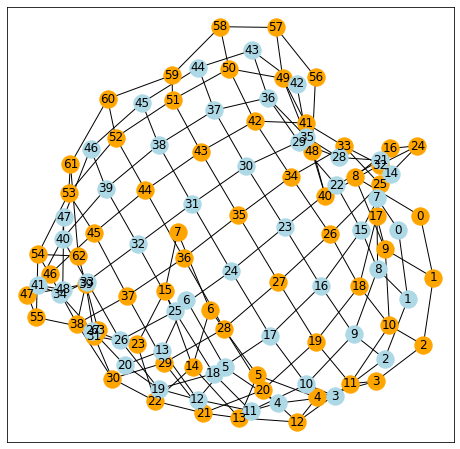

In [13]:
gpn = GrowingPlanarNetwork()
gpn.init_square(8)
gpn.show_all(figsize=(8, 8))

In [14]:
"""
k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
k_p = 0.9 * k_n
"""
pass
# This is the formula to adapt k (1/Tc) according to progenitor

In [15]:
from enum import Enum
    
class CellTypeGP(Enum):
    RG = 0
    IP = 1
    PostMitotic = 2
    Dead = 3
    GP = 4

In [16]:
type(1)(9)

9

In [17]:
class CellTriStateBasic(AbstractCell):
    """
    Tc will require 2 functions, one for RG and one for IP
    diff function will output p_RG, p_IP for RG
    and p_IP, p_N for IP.
    
    Tuning this model will require to have the proportion of Tbr2+ and Tbr2-
    in the progenitor population.
    """
    def __init__(self, T, start=False, brain=None, index=None, parent_type=None, submodel=None):
        # references
        self.brain = brain
        self.submodel = submodel
        
        # cell data
        self.appear_time = T
        self.division_time = np.Inf
        self.index = index
        
        if start:
            self._type = CellTypeGP.RG
        else:
            self._type = self.submodel.diff(T, parent_type)
        
        if self._type in [CellTypeGP.RG, CellTypeGP.IP, CellTypeGP.GP]:
            self.cycle(T, start)
            
    def tick(self, abs_time, rel_time, neighbours=None):
        if self._type == CellTypeGP.PostMitotic:
            return Action.DiffNeuron
        
        elif abs_time > self.division_time:
            return Action.Divide
        
        else:
            return Action.NoOp
            
    def cycle(self, T, start=False):
        self.Tc = self.submodel.Tc(T, self.type())
        if start:
            self.eff_Tc = np.random.uniform(0, self.Tc)
        else:
            self.eff_Tc = self.Tc
        self.division_time = T + self.eff_Tc
    
    def __gt__(self, C):
        return self.division_time > C.division_time
    
    def generate_daughter_cell(self, T):
        return CellTriStateBasic(T, start=False, brain=self.brain, parent_type=self.type(),
                                submodel=self.submodel)

In [18]:
class TriStateModelFactory:
    def __init__(self,
                 timesteps=[49, 61, 72, 83, 95],
                 tc_coeff_RG=[1., 1., 1., 1., 1.],
                 tc_coeff_IP=[1., 1., 1., 1., 1.],
                 diff_coeff_RG=[1., 1., 1., 1., 1.],
                 diff_coeff_IP=[1., 1., 1., 1., 1.],
                 diff_values_RG_IP=[0.73, 0.63, 0.53, 0.43, 0.43], # rather RG_low
                 diff_values_RG_GP=[1., 1., 1., 0.8, 0.6], # rather RG_high
                 diff_values_IP=[0.23, 0.23, 0.23, 0.23, 0.23],
                ):
        # DIFF
        # values are value to self renew, over value to differentiate
        # lin_diff_RG = interp1d(timesteps, [x*y for x, y in zip(diff_values_RG, diff_coeff_RG)])
        # lin_diff_IP = interp1d(timesteps, [x*y for x, y in zip(diff_values_IP, diff_coeff_IP)])
        lin_diff_RG_IP = interp1d(timesteps, diff_values_RG_IP)
        lin_diff_RG_GP = interp1d(timesteps, diff_values_RG_GP)
        lin_diff_IP_ = interp1d(timesteps, diff_values_IP)
        # lin_diff_RG = lambda x: lin_diff_RG_(x) * diff_coeff_RG[highest_lower(timesteps, x)]
        lin_diff_IP = lambda x: lin_diff_IP_(x) * diff_coeff_IP[highest_lower(timesteps, x)]
        
        # TC
        Tc_IP = lambda x: Tc_(x) * tc_coeff_IP[highest_lower(timesteps, x)]
        Tc_RG = lambda x: Tc_(x) * tc_coeff_RG[highest_lower(timesteps, x)]
        
        def repr_():
            timesteps = np.arange(49, 95, 0.1)
            fig = plt.figure(figsize=(12, 8))
            fig.suptitle("Parameters of submodel 2", fontsize=14)

            plt.subplot(2, 2, 1)
            plt.title("Diff RG")
            plt.ylim(-0.05, 1.05)
            plt.plot(timesteps, list(map(lin_diff_RG_IP, timesteps)))
            plt.plot(timesteps, list(map(lin_diff_RG_GP, timesteps)))

            plt.subplot(2, 2, 2)
            plt.title("Diff IP")
            plt.ylim(-0.05, 1.05)
            plt.plot(timesteps, list(map(lin_diff_IP, timesteps)))

            plt.subplot(2, 2, 3)
            plt.ylim(-5, 105)
            plt.title(f"Tc (h) RG, sigma={SIG_TC}, min=10")
            plt.plot(timesteps, list(map(Tc_RG, timesteps)))

            plt.subplot(2, 2, 4)
            plt.ylim(-5, 105)
            plt.title(f"Tc (h) IP, sigma={SIG_TC}, min=10")
            plt.plot(timesteps, list(map(Tc_IP, timesteps)))
            
        def tc_func_bistate(time_, type_):
            if type_ == CellTypeGP.RG:
                return max(np.random.normal(Tc_RG(time_), SIG_TC), 10) / 24. # because we are in Days
            
            elif type_ == CellTypeGP.IP:
                return max(np.random.normal(Tc_IP(time_), SIG_TC), 10) / 24. # because we are in Days
            
            elif type_ == CellTypeGP.GP:
                return max(np.random.normal(Tc_RG(time_), SIG_TC), 10) / 24. * 100 # because we are in Days

        def diff_func_bistate(time_, type_):
            if type_ == CellTypeGP.RG:
                val1 = lin_diff_RG_IP(time_)
                val2 = lin_diff_RG_GP(time_)
                return choice([CellTypeGP.RG, CellTypeGP.IP, CellTypeGP.GP], 1,
                              p=[val1, val2 - val1, 1 - val2])[0]

            elif type_ == CellTypeGP.IP:
                val = lin_diff_IP(time_)
                return choice([CellTypeGP.IP, CellTypeGP.PostMitotic], 1, p=[val, 1-val])[0]
            
            elif type_ == CellTypeGP.GP:
                return CellTypeGP.GP


        self.model = Submodels(tc_func_bistate, diff_func_bistate, repr_=repr_)
        
    def generate(self, *args, **kwargs):
        return CellTriStateBasic(*args, **kwargs, submodel=self.model)

In [19]:
# random.seed(0+0)
# np.random.seed(0+0)
# ccls = TriStateModelFactory(diff_values_RG_GP=[1., 1., 1., 0.85, 0.6])
# exp = Experiment(time_step=0.5, verbose=False, start_population=3, cell_cls=ccls.generate,
#                  check=False, cls_=Brain, safe_mode=False)
# exp.run()

In [20]:
# with Profiler():
#     random.seed(0+0)
#     np.random.seed(0+0)
#     ccls = BiStateModelFactory(tc_coeff_RG=[1., 1., 1., 1., 1.])
#     exp = Experiment(time_step=0.5, verbose=False, start_population=3, cell_cls=ccls.generate,
#                      check=False, cls_=Brain)
#     exp.run()

In [21]:
random.seed(0+0)
np.random.seed(0+0)
ccls = BiStateModelFactory(tc_coeff_RG=[1., 1., 1., 1., 1.])
bb = Brain(time_step=0.5, verbose=False, start_population=3, cell_cls=ccls.generate, check=False)
bb.run()

In [22]:
bb.stats

,progenitor_pop_size,whole_pop_size,time,size_type_RG,size_type_IP,size_type_PostMitotic
49.0,3.0,3.0,49.0,9.0,NaN,NaN
49.0,9.0,9.0,49.0,9.0,NaN,NaN
49.5,11.0,11.0,49.5,10.0,1.0,NaN
50.0,11.0,11.0,50.0,10.0,1.0,NaN
50.5,16.0,16.0,50.5,14.0,2.0,NaN
...,...,...,...,...,...,...
91.5,193.0,2722.0,91.5,34.0,116.0,43.0
92.0,171.0,2743.0,92.0,35.0,118.0,18.0
92.5,181.0,2771.0,92.5,31.0,115.0,35.0
93.0,183.0,2808.0,93.0,29.0,108.0,46.0


In [42]:
A = bb.root_population[0]
A

In [24]:
tree = tree_from_cell(A)

In [30]:
for node in tree.get_leaves():
    print(node.name)
    break

1981


In [50]:
bb.population[1981].appear_time

74.5

In [43]:
a = tree.get_children()[0]
b = a.get_children()[0]
c = b.get_children()[0]
d = c.get_children()[0]
a, b, c, d

(Tree node '0' (0x7ff63cfdd24),
 Tree node '23' (-0x7ffff800977cc169),
 Tree node '47' (-0x7ffff800977cb7e0),
 Tree node '89' (0x7ff6883599b))

In [49]:
from collections import Counter

def count_total_progeny(cell, brain, only_leaves=True):
    if isinstance(cell, int):
        cell = brain.population[cell]
        
    tree = tree_from_cell(cell)
    if only_leaves:
        nodes = tree.get_leaves()
    else:
        nodes = list(tree.traverse())
        nodes = [n for n in nodes if isinstance(n.name, int)]
        
    res = Counter(list(map(lambda x: brain.population[x.name].type(), nodes)))
    return res

print(count_total_progeny(A, bb, only_leaves=False))
print(count_total_progeny(A, bb, only_leaves=True))

print(count_total_progeny(b.name, bb, only_leaves=False))
print(count_total_progeny(b.name, bb, only_leaves=True))

print(count_total_progeny(c.name, bb, only_leaves=False))
print(count_total_progeny(c.name, bb, only_leaves=True))

print(count_total_progeny(d.name, bb, only_leaves=False))
print(count_total_progeny(d.name, bb, only_leaves=True))

Counter({<CellTypeClassic.PostMitotic: 2>: 360, <CellTypeClassic.IP: 1>: 257, <CellTypeClassic.RG: 0>: 138})
Counter({<CellTypeClassic.PostMitotic: 2>: 360, <CellTypeClassic.IP: 1>: 15, <CellTypeClassic.RG: 0>: 3})
Counter({<CellTypeClassic.PostMitotic: 2>: 287, <CellTypeClassic.IP: 1>: 208, <CellTypeClassic.RG: 0>: 114})
Counter({<CellTypeClassic.PostMitotic: 2>: 287, <CellTypeClassic.IP: 1>: 15, <CellTypeClassic.RG: 0>: 3})
Counter({<CellTypeClassic.PostMitotic: 2>: 283, <CellTypeClassic.IP: 1>: 205, <CellTypeClassic.RG: 0>: 113})
Counter({<CellTypeClassic.PostMitotic: 2>: 283, <CellTypeClassic.IP: 1>: 15, <CellTypeClassic.RG: 0>: 3})
Counter({<CellTypeClassic.PostMitotic: 2>: 109, <CellTypeClassic.IP: 1>: 83, <CellTypeClassic.RG: 0>: 51})
Counter({<CellTypeClassic.PostMitotic: 2>: 109, <CellTypeClassic.IP: 1>: 11, <CellTypeClassic.RG: 0>: 2})


In [57]:
def df_cells(pop):
    times = list(map(lambda x: x.appear_time, pop.values()))
    types = list(map(lambda x: x.type().name, pop.values()))
    index = list(map(lambda x: x.index, pop.values()))
    return pd.DataFrame({"cell": index, "appear_time": times, "type": types})

df_cells(bb.population)

,cell,appear_time,type
0,0,49.0,RG
1,1,49.0,RG
2,2,49.0,RG
3,3,49.0,RG
4,4,49.0,RG
...,...,...,...
5648,5648,93.5,PostMitotic
5649,5649,93.5,PostMitotic
5650,5650,93.5,PostMitotic
5651,5651,93.5,IP


In [83]:
def progeny_along_time(brain, _type="RG", only_leaves=True, window=2.):
    df = df_cells(brain.population)
    
    ret_df = pd.DataFrame()
    
    times = sorted(df["appear_time"].unique())
    min_time = min(df["appear_time"])
    max_time = max(df["appear_time"])
    for T in np.arange(min_time, max_time, window):
        count_T = Counter()
        df_T = df[(df["appear_time"] >= T) & (df["appear_time"] < T + window) & (df["type"] == _type)]
        N = len(df_T)
        if not N:
            continue
            
        for i, cell in df_T.iterrows():
            progeny = count_total_progeny(cell["cell"], brain, only_leaves=only_leaves)
            count_T.update(progeny)
            
        new_row = dict(count_T)
        new_row = {k.name: v / N for k, v in new_row.items()}
        new_row["time"] = T
        ret_df = ret_df.append(new_row, ignore_index=True)
        
    ret_df = ret_df.fillna(0.0)
        
    return ret_df
        
progeny = progeny_along_time(bb)

In [ ]:
plt.plot(progeny["time"], progeny["RG"])
plt.plot(progeny["time"], progeny["RG"] + progeny["IP"])

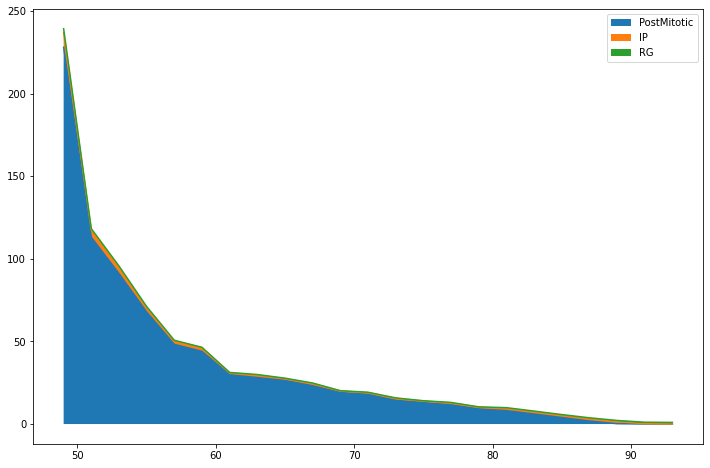

In [92]:
# plotting
def plot_progeny(progeny):
    plt.figure(figsize=(12, 8))
    types = set(progeny.columns) - {"time"}
    
    cum = 0
    for t_ in types:
        plt.plot(progeny["time"], cum + progeny[t_])
        plt.fill_between(progeny["time"], cum, cum + progeny[t_], label=t_)
        cum += progeny[t_]
        
    plt.legend()

plot_progeny(progeny)

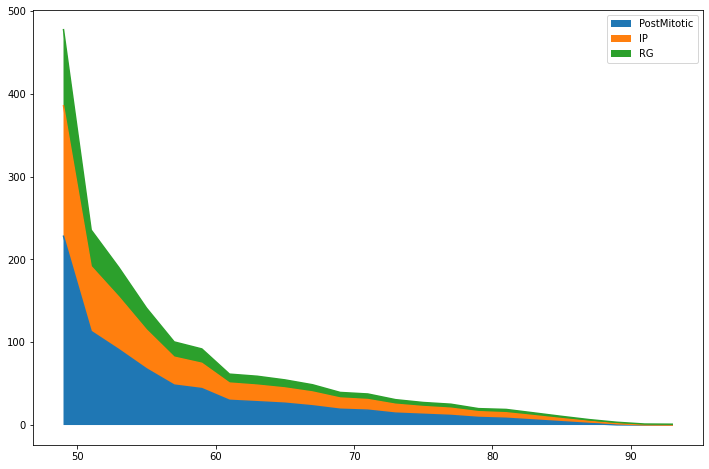

In [93]:
progeny_all = progeny_along_time(bb, only_leaves=False)
plot_progeny(progeny_all)

In [25]:
raise

RuntimeError: No active exception to reraise

## Experimenting

In [ ]:
def condition_number(obj):
    dist = obj.get_final_dist("whole_pop_size")
    mu, sigma, N = np.mean(dist), np.std(dist), len(dist)
    if N < 3:
        return False
    CI = stats.norm.interval(0.90, loc=mu, scale=sigma/np.sqrt(N))
    _range = CI[1] - CI[0]
    
    cond = _range < 0.01 * mu  # relative
    if cond:
        print(_range, 0.01 * mu, np.min(dist), np.max(dist), np.percentile(dist, 10), np.percentile(dist, 90))
        
    return cond

# robustness = 1 / unstability
def run_robustness_analysis(coeff=1.1, number=30, seed=0, start_population=5, max_number=200):
    results = pd.DataFrame(dict(param=[],
                               coeff=[],
                               variation_neuron=[],
                               neurons_std=[],
                               baseline_neuron=[],
                               baseline_neuron_std=[],
                               unstability_neuron=[],
                               robustness_neuron=[],
                               variation_ratio=[],
                               ratio_std=[],
                               baseline_ratio=[],
                               baseline_ratio_std=[],
                               unstability_ratio=[],
                               robustness_ratio=[]))
    
    # get baselines
    print("Computing baselines")
    random.seed(seed)
    np.random.seed(seed)
    # ccls = BiStateModelFactory()
    t_ = ("bistate1", (), {})
    exp = Experiment(time_step=0.5, verbose=False, start_population=start_population,
                     cell_cls=t_, max_number=max_number,
                     check=False, cls_=Brain)
    exp.run_parallel(condition_number)
    baseline_neuron = exp.get_final("whole_pop_size")
    baseline_neuron_std = exp.get_final_std("whole_pop_size", mean=True)
    baseline_ratio = exp.get_final_ratio()
    baseline_ratio_std = exp.get_final_ratio_std()
    
    plt.ioff()
    print("Starting Robustness experiment")
    for param in ["tc_coeff_RG", "tc_coeff_IP", "diff_coeff_RG", "diff_coeff_IP"]:
        for t in range(4):
            kw = {param: [1. if i != t else coeff for i in range(5)]}
            print(f"{param}_{t} with {kw}")
            ccls = BiStateModelFactory(**kw)
            t_ = ("bistate1", (), kw)
            random.seed(seed)
            np.random.seed(seed)
            exp = Experiment(time_step=0.5, verbose=False, start_population=start_population,
                             cell_cls=t_, number=number, max_number=max_number,
                             check=False, cls_=Brain)
            exp.run_parallel(condition_number)
            
            neurons = exp.get_final("whole_pop_size")
            print(exp.get_final_dist("whole_pop_size"))
            neurons_std = exp.get_final_std("whole_pop_size", mean=True)
            print(neurons_std)
            ratio = exp.get_final_ratio()
            ratio_std = exp.get_final_ratio_std()
            
            unstability_neuron = (neurons - baseline_neuron) / baseline_neuron
            unstability_ratio = (ratio - baseline_ratio) / baseline_ratio
            
            dd = dict(
                param=param + "_" + str(t),
                coeff=coeff,
                variation_neuron=neurons - baseline_neuron,
                baseline_neuron=baseline_neuron,
                baseline_neuron_std=baseline_neuron_std,
                neurons_std=neurons_std,
                unstability_neuron=unstability_neuron,
                robustness_neuron=abs(1 / (1e-6 + unstability_neuron)),
                variation_ratio=ratio - baseline_ratio,
                ratio_std=ratio_std,
                baseline_ratio=baseline_ratio,
                baseline_ratio_std=baseline_ratio_std,
                unstability_ratio=unstability_ratio,
                robustness_ratio=abs(1 / (1e-6 + unstability_ratio)),
            )
            results = results.append(dd, ignore_index=True)
            
            # saving figures
            exp.show_pop()
            plt.savefig(f"output/stack/population_{param}_{t}.png")
            plt.close()
            exp.show_progenitor_pop()
            plt.savefig(f"output/stack/progenitor_{param}_{t}.png")
            plt.close()
            exp.show_ratio_IP(ratio_eomes)
            plt.savefig(f"output/stack/ratio_IP_{param}_{t}.png")
            plt.close()

    plt.close()
    plt.ion()
    return results

In [ ]:
# random.seed(0+0)
# np.random.seed(0+0)
# ccls = BiStateModelFactory(tc_coeff_RG=[1., 1., 1., 1., 1.])
# bb = Brain(time_step=0.5, verbose=False, start_population=3, cell_cls=CellBasic, check=False)
# bb.run()
# raise

In [ ]:
results = run_robustness_analysis(number=30, seed=0, start_population=5, max_number=200)
results.to_csv("output/robustness_rect4.csv")
results.head()

In [ ]:
results

In [ ]:
raise

In [ ]:
results.append(dict(param=0,
                   coeff=0,
                   variation=0,
                   baseline=0,
                   unstability=0,
                   robustness=0), ignore_index=True)

In [ ]:
plt.figure(figsize=(20, 20))
Counter(dict(bb.gpn.G.degree()).values())

In [ ]:
bb.stats

In [ ]:
plt.figure(figsize=(10, 10))
p1 = plt.plot(bb.stats.time, bb.stats.progenitor_pop_size, label="Progenitor population")
p2 = plt.plot(bb.stats.time, bb.stats.whole_pop_size, label="Whole Population")
plt.legend()
# plt.legend((p1, p2), ("Progenitor population", "Whole Population"))

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(bb.stats.time, bb.stats.size_type_RG, label="RG number")
plt.plot(bb.stats.time, bb.stats.size_type_IP, label="IP number")
plt.legend()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(bb.stats.time, bb.stats.size_type_IP / (bb.stats.size_type_RG + bb.stats.size_type_IP),
         label="IP ratio")
plt.plot(ratio_eomes.index, ratio_eomes.val / 100, label="Reference IP ratio")
plt.legend()

In [ ]:
raise